In [1]:
from IPython.utils import io
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import seaborn as sns
import time
import joblib
from os.path import exists
import shutil
import sys
import time
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
#From my EEG package 
import run_expts
import constants

from scipy import stats
import scikit_posthocs as sp

#Let me see as many results as I want to see
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [17]:
clf_list = ['Random_Forest' , 'SVC']

#Results dictionary structure : {model : {expt_type : {folder : results_df }}}
results_dict = {}
for clf in clf_list:
    results_dict[clf] = {1 : {} , 2 : {} , 3: {} , 4 : {}}

core_path = '/export/sphere/ebirah/ko20929/RBD_files/notebooks/frequency_analysis/constructed_data/band_power_time_series/expt_dfs/'

folders = ['N1_full_expts', 'N2_full_expts', 'N3_full_expts', 'REM_full_expts', 'EC_full_expts']

files_not_found = []

for num in [1,2,3,4]:
    for folder in folders:
        for clf in clf_list:
            try:
                save_path = 'Results/Results_4/' + clf + 'expt_type_' + str(num) + '_' + folder[:3] + 'int_df.h5'
                results_df = pd.read_hdf(save_path , key='df', mode='r')
            except FileNotFoundError:
                files_not_found.append(save_path)
                continue
                
            res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)           
            results_dict[clf][num][folder] = res_df
            
#Put results in a Df structure that is easy to plot etc....  
#Defining the dataframe dictionary to be filled up

expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD  multiclass', 
             '4. PD vs PD+RBD vs RBD vs HC  multiclass' ]

df_cols = ['Expt_type num', 'Folder', 'Classifier Name', 'Classifier', 'EEG Type',
       'Brain Region', 'Accuracy', 'Accuracy_std', 'TS processing']

df_dict = {}
for col in df_cols:
    df_dict[col] = []

regions = constants.regions

for clf in clf_list:
    for folder in folders:
        #Define EEG type from folder
        for eeg_type in ['N1' , 'N2' , 'N3' , 'REM' , 'EC']:
            if folder.startswith(eeg_type):
                eeg_type_res = eeg_type
        proc = 'N/A'
        for expt_num in [1,2,3,4]:
            #Fill up the results_dict with the appropriate values
            #Grab accuracy and std performance for each region
            try:
                mean_df = pd.DataFrame(results_dict[clf][expt_num][folder].mean(axis = 0) ).T
            
            except KeyError:
                continue
            for region in regions:
                #For each region take mean accuracy and std
                region_cols = [col for col in mean_df.columns if region in col]
                acc_col = [col for col in region_cols if 'acc' in col]
                std_col = [col for col in region_cols if 'std' in col]
                region_acc = mean_df[acc_col].values[0][0]
                region_acc_std = mean_df[std_col].values[0][0]
                
                #Now fill up the dataframe
                df_dict['Expt_type num'].append(expt_num)
                df_dict['Folder'].append(folder)
                df_dict['Classifier Name'].append(clf)
                df_dict['Classifier'].append(clf)
                df_dict['EEG Type'].append(eeg_type_res)
                df_dict['Brain Region'].append(region)
                df_dict['Accuracy'].append(region_acc)
                df_dict['Accuracy_std'].append(region_acc_std)
                df_dict['TS processing'].append(proc)

results_df = pd.DataFrame(df_dict)

## This portion of the notebook plots accuracy by region (to view trends)

In [18]:
results_df_sorted = results_df.sort_values(by = ['Accuracy'], ascending = False)
results_df_sorted.head(12)

,Expt_type num,Folder,Classifier Name,Classifier,EEG Type,Brain Region,Accuracy,Accuracy_std,TS processing
73,2,N2_full_expts,Random_Forest,Random_Forest,N2,Right Temporal,0.698889,0.170806,N/A
221,2,EC_full_expts,Random_Forest,Random_Forest,EC,Prefrontal,0.696429,0.103978,N/A
224,2,EC_full_expts,Random_Forest,Random_Forest,EC,Right Frontal,0.680357,0.146775,N/A
160,1,REM_full_expts,Random_Forest,Random_Forest,REM,Central,0.662500,0.165831,N/A
215,1,EC_full_expts,Random_Forest,Random_Forest,EC,Left Temporal,0.636667,0.182698,N/A
209,1,EC_full_expts,Random_Forest,Random_Forest,EC,Frontal,0.626667,0.187110,N/A
56,1,N2_full_expts,Random_Forest,Random_Forest,N2,Central,0.623611,0.140554,N/A
60,1,N2_full_expts,Random_Forest,Random_Forest,N2,Right Temporal,0.620833,0.110697,N/A
313,1,N2_full_expts,SVC,SVC,N2,Frontal,0.618056,0.182270,N/A
211,1,EC_full_expts,Random_Forest,Random_Forest,EC,Right Frontal,0.616667,0.164212,N/A


In [4]:
expt_results['Accuracy'].max()

NameError: name 'expt_results' is not defined

<Figure size 640x480 with 0 Axes>

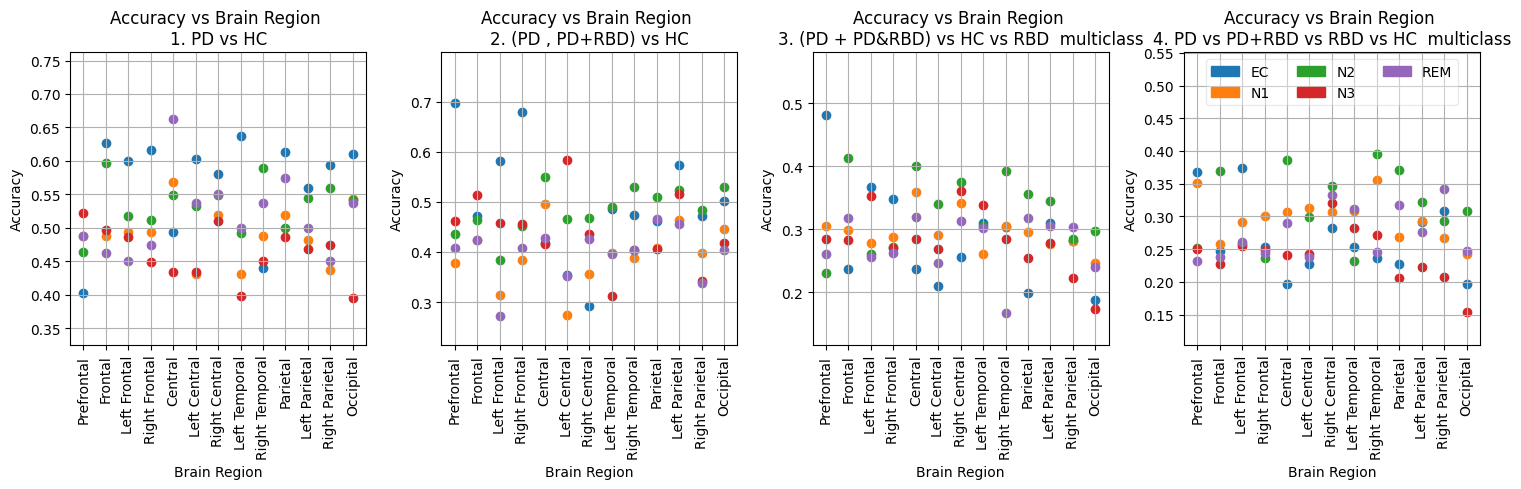

<Figure size 640x480 with 0 Axes>

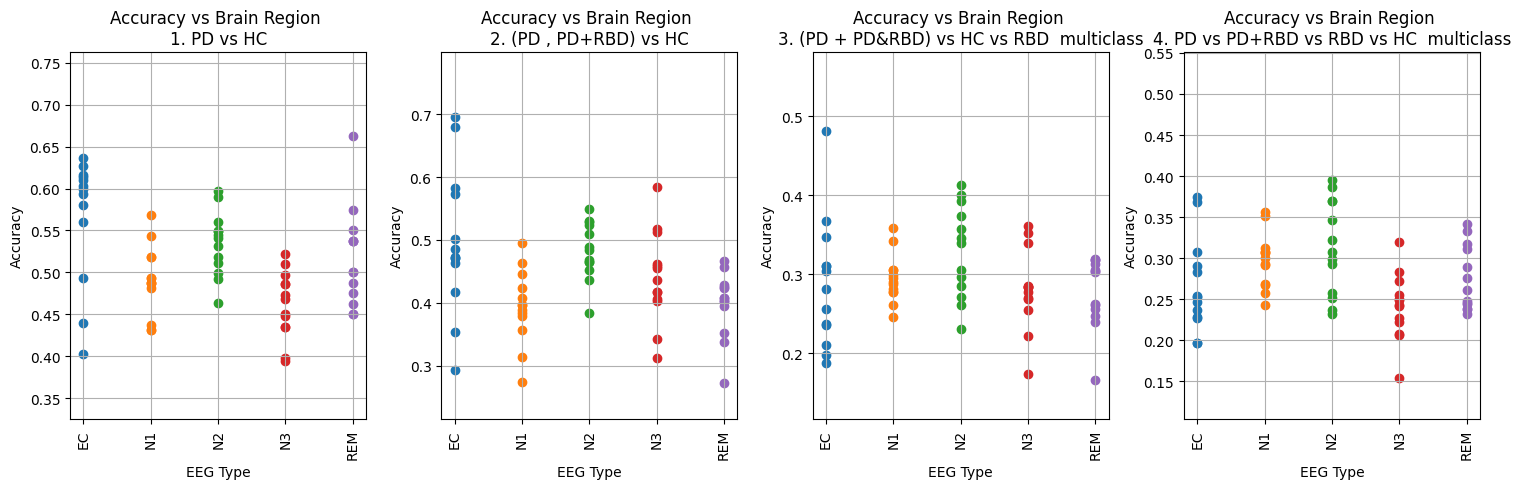

In [19]:
fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type num'] == expt_num].copy()
    expt_results.sort_values(by=['Brain Region','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs Brain Region \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'EC':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
#     plt.scatter(expt_results['Brain Region'].values, expt_results['Accuracy'].values,
#                     c = expt_results['EEG Type'].map(colors))

    #Plot one data point per region / data type combination - average the performance across short and long processing
    for eeg_type in ['EC', 'N1', 'N2', 'N3', 'REM']:
        for region in regions:
            acc = expt_results[(expt_results['Brain Region'] == region) & (expt_results['EEG Type'] == eeg_type)].mean(numeric_only = True)['Accuracy']
            plt.scatter(region, acc,
                    c = colors[eeg_type])
    
   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('Brain Region')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

# plt.legend(handles=patches, framealpha = 0.1)
plt.legend(loc = 'upper center', ncol = 3 ,  handles=patches, framealpha = 0.4)
    
plt.tight_layout()

#Do the plots again for data type accuracy distribution
fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type num'] == expt_num].copy()
    expt_results.sort_values(by=['Brain Region','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs Brain Region \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'EC':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
#     plt.scatter(expt_results['Brain Region'].values, expt_results['Accuracy'].values,
#                     c = expt_results['EEG Type'].map(colors))

    #Plot one data point per region / data type combination - average the performance across short and long processing
    for eeg_type in ['EC', 'N1', 'N2', 'N3', 'REM']:
        for region in regions:
            acc = expt_results[(expt_results['Brain Region'] == region) & (expt_results['EEG Type'] == eeg_type)].mean(numeric_only = True)['Accuracy']
            plt.scatter(eeg_type, acc,
                    c = colors[eeg_type])
    
   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('EEG Type')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

plt.tight_layout()


# plt.savefig('classifier_accuracy_original_epoch_bpw.png', dpi=200) 

#### Do statistical significance tests

In [10]:
results_df = results_df[results_df['Classifier'] == 'Random_Forest']
rocket_results = results_df[results_df['Expt_type num'] == 4] 
rocket_results

,Expt_type num,Folder,Classifier Name,Classifier,EEG Type,Brain Region,Accuracy,Accuracy_std,TS processing
39,4,N1_full_expts,Random_Forest,Random_Forest,N1,Prefrontal,0.351429,0.116103,N/A
40,4,N1_full_expts,Random_Forest,Random_Forest,N1,Frontal,0.260952,0.083265,N/A
41,4,N1_full_expts,Random_Forest,Random_Forest,N1,Left Frontal,0.316190,0.106516,N/A
42,4,N1_full_expts,Random_Forest,Random_Forest,N1,Right Frontal,0.325238,0.079251,N/A
43,4,N1_full_expts,Random_Forest,Random_Forest,N1,Central,0.317619,0.122890,N/A
44,4,N1_full_expts,Random_Forest,Random_Forest,N1,Left Central,0.335714,0.107214,N/A
45,4,N1_full_expts,Random_Forest,Random_Forest,N1,Right Central,0.345714,0.157671,N/A
46,4,N1_full_expts,Random_Forest,Random_Forest,N1,Left Temporal,0.255238,0.100753,N/A
47,4,N1_full_expts,Random_Forest,Random_Forest,N1,Right Temporal,0.330476,0.114121,N/A
48,4,N1_full_expts,Random_Forest,Random_Forest,N1,Parietal,0.317619,0.095981,N/A


In [11]:
regional_means, eeg_type_means = {} , {}
for region in regions:
    regional_means[region] = round(rocket_results[rocket_results['Brain Region'] == region].mean(numeric_only= True)['Accuracy'],3)

for eeg_type in ['EC', 'N1', 'N2', 'N3', 'REM']:
    eeg_type_means[eeg_type] = round(rocket_results[rocket_results['EEG Type'] == eeg_type].mean(numeric_only= True)['Accuracy'],3)

print(regional_means)
print('\n')
print(eeg_type_means)

{'Prefrontal': 0.287, 'Frontal': 0.269, 'Left Frontal': 0.291, 'Right Frontal': 0.261, 'Central': 0.299, 'Left Central': 0.258, 'Right Central': 0.33, 'Left Temporal': 0.263, 'Right Temporal': 0.296, 'Parietal': 0.286, 'Left Parietal': 0.278, 'Right Parietal': 0.286, 'Occipital': 0.232}


{'EC': 0.267, 'N1': 0.303, 'N2': 0.313, 'N3': 0.241, 'REM': 0.275}


In [12]:
pd.DataFrame(regional_means, index = ['mean_acc']).T.sort_values(by = ['mean_acc']).T

,Occipital,Left Central,Right Frontal,Left Temporal,Frontal,Left Parietal,Parietal,Right Parietal,Prefrontal,Left Frontal,Right Temporal,Central,Right Central
mean_acc,0.232,0.258,0.261,0.263,0.269,0.278,0.286,0.286,0.287,0.291,0.296,0.299,0.33


In [13]:
pd.DataFrame(eeg_type_means, index = ['mean_acc']).T.sort_values(by = ['mean_acc']).T

,N3,EC,REM,N1,N2
mean_acc,0.241,0.267,0.275,0.303,0.313


In [14]:
#1. generate the dfs 
regional_acc_distribution , eeg_type_distribution = {} , {}

for eeg_type in ['EC', 'N1', 'N2', 'N3', 'REM']:
    eeg_type_distribution[eeg_type] = rocket_results[rocket_results['EEG Type'] == eeg_type]['Accuracy'].values

for region in regions:
    regional_acc_distribution[region] = rocket_results[rocket_results['Brain Region'] == region]['Accuracy'].values

eeg_type_dist = pd.DataFrame(eeg_type_distribution)
regional_acc_dist = pd.DataFrame(regional_acc_distribution)

In [15]:
print(stats.friedmanchisquare(*eeg_type_dist.T.values) ) 
output_results = sp.posthoc_nemenyi_friedman(eeg_type_dist.values)

column_mapping = {0: 'EC', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
row_mapping = {0: 'EC', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
df = output_results.rename(columns=column_mapping, index=row_mapping)
df

FriedmanchisquareResult(statistic=10.892307692307696, pvalue=0.027801363961457087)


,EC,N1,N2,N3,REM
EC,1.000000,0.339031,0.413055,0.900000,0.900000
N1,0.339031,1.000000,0.900000,0.049861,0.560634
N2,0.413055,0.900000,1.000000,0.069613,0.631024
N3,0.900000,0.049861,0.069613,1.000000,0.701418
REM,0.900000,0.560634,0.631024,0.701418,1.000000


In [16]:
print(stats.friedmanchisquare(*regional_acc_dist.T.values) ) 

output_results = sp.posthoc_nemenyi_friedman(regional_acc_dist.values)

column_mapping = {}
for i in range(len(regional_acc_dist.columns)): 
    column_mapping[i] = list(regional_acc_dist.columns)[i]
row_mapping = column_mapping    
    
df = output_results.rename(columns=column_mapping, index=row_mapping)
df

FriedmanchisquareResult(statistic=13.676567656765684, pvalue=0.3218370949182442)


,Prefrontal,Frontal,Left Frontal,Right Frontal,Central,Left Central,Right Central,Left Temporal,Right Temporal,Parietal,Left Parietal,Right Parietal,Occipital
Prefrontal,1.000000,0.900000,0.900000,0.90000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.865946
Frontal,0.900000,1.000000,0.900000,0.90000,0.900000,0.900000,0.531317,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
Left Frontal,0.900000,0.900000,1.000000,0.90000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.685759
Right Frontal,0.900000,0.900000,0.900000,1.00000,0.900000,0.900000,0.660020,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
Central,0.900000,0.900000,0.900000,0.90000,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.865946
Left Central,0.900000,0.900000,0.900000,0.90000,0.900000,1.000000,0.531317,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
Right Central,0.900000,0.531317,0.900000,0.66002,0.900000,0.531317,1.000000,0.840202,0.900000,0.814465,0.891684,0.891684,0.061218
Left Temporal,0.900000,0.900000,0.900000,0.90000,0.900000,0.900000,0.840202,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000
Right Temporal,0.900000,0.900000,0.900000,0.90000,0.900000,0.900000,0.900000,0.900000,1.000000,0.900000,0.900000,0.900000,0.582799
Parietal,0.900000,0.900000,0.900000,0.90000,0.900000,0.900000,0.814465,0.900000,0.900000,1.000000,0.900000,0.900000,0.900000
